`Copyright (c) Meta Platforms, Inc. and affiliates. This source code is licensed under the CC-BY-NC license found in the LICENSE file in the root directory of this source tree.`

# Battery capacity estimation methods

#### This notebook contains the different search methods to estimate the minimum battery capacity to support a data center with 24/7 green energy supply. The methods are:
* Sequential search
* Binary search
* Hybrid search
* Parallel hybrid search

We compare the results of these methods by result and execution time. 
The results are plotted and saved.

# 1. Data preparation and configuration

## 1.1 import libraries
assume EIA dataset is already downloaded and unzipped


In [8]:
import os
import sys
# Join the parent of the current working directory to the path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from download_and_process import *


In [9]:
# The EIA dataset is located 2 levels up from this file in the EBA directory
EIA_data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'EBA'))

## 1.2. Prepare EIA energy source data for processing

**`prepareEIAData():`** Reads the EIA bulk json file and converts it into a data frame.

Populates `ba_list`, which is a list of all balancing authorities in the US.

Populates `eba_json`, which will be used later for `extractBARange` function.

In [10]:
print("Preparing the EIA data...\n")
eba_json, ba_list, ta_list = prepareEIAData(EIA_data_dir)

print("List of all balancing authorities: \t", ba_list)

Preparing the EIA data...

EIA data prep done!
List of all balancing authorities: 	 ['BANC', 'BPAT', 'CENT', 'CHPD', 'SCEG', 'SEPA', 'SOCO', 'NE', 'NW', 'NY']


## 1.3. Configure Carbon Explorer

In [11]:
# SET the values below in order to customize this notebook
#
# Folder containing the EIA's extracted bulk data
EIA_bulk_data_dir = EIA_data_dir

# <dc_ba_map>: map of datacenters to be analyzed
# Add/remove datacenters to/from this map which contains
# datacenter locations (state) and corresponding balancing authority (BA)
# Find which the map of BA's in the U.S. here:
# https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
dc_ba_map = {
    "OR": "BPAT",
    "NC": "DUK",
    "UT": "PACE",
}

# <dc_power_map>: map of average DC power capacity in MW
dc_power_map = {
    "OR": 50,
    "NC": 50,
    "UT": 50,
}

# <ba_ppa_map>: map of renewable [wind, solar] investment amounts (in MW) you want to make for each grid (BA)
ba_ppa_map = {
    "BPAT": [500, 0],   # 500 MW wind farm, no solar farm
    "DUK": [0, 410],    # no wind farm, 410 MW solar farm
    "PACE": [239, 694], # 239 MW wind, 694 MW solar farm
}

# Default data range to analyze: [START_DATE, END_DATE]
# EIA's bulk data starts from July 2018 and gets updated daily
# Any date range between mid 2018 to downlaod date can be selected
# Note that longer time frames increases evaluation time.
START_DATE = "2021-01-01"
END_DATE = "2021-01-05"

# Embodied Carbon Footprint Numbers
# numbers are taken from the corresponding links below
# Battery
# https://www.forbes.com/sites/rrapier/2020/02/16/estimating-the-carbon-footprint-of-utility-scale-battery-storage/?sh=1dc64eb97adb
embodied_battery_footprint = 74 #tons of CO2 per MWh batttery capacity, when manufacturing is fully renewable
#embodied_battery_footprint = 134 #tons of CO2 per MWh batttery capacity, when manufacturing is not renewable
cycles = 3000
battery_lifetime = cycles/365  # years
# Servers
# https://www.hpe.com/psnow/doc/a50002430enw?jumpid=in_lit-psnow-red
dc_footprint_surcharge = 1.15 # addtional footprint for non-server components
embodied_server_footprint = (744.5/120)*dc_footprint_surcharge # tons per MW
server_lifetime = 4 # years
# Solar and wind farms
# https://www.nrel.gov/analysis/life-cycle-assessment.html
# https://www.nrel.gov/analysis/assets/images/lca_harm_ng_fig_2.jpg
# https://yaleclimateconnections.org/2021/06/whats-the-carbon-footprint-of-a-wind-turbine/
# These numbers are derived from a life cycle analysis and accounts for its manufacturing cost and the expected amount of energy generated.
embodied_solar_farm_footprint = 55 # kg of CO2 per MWh
embodied_wind_farm_footprint = 12 # kg of CO2 per MWh

## 1.4. Simulate Hourly Datacenter Power Load
**`extractDCRange(region, start_day, end_day, swing_percentage=5):`**  Returns a dataframe of DC power for the given date range set as index. Hourly DC power is simulated as a sine wave with the given fluctuation/swing percentage.

**`region`**: state of the DC, must be an item in the `dc_power_map`

**`START_DATE`**: i.e. "2021-01-01"

**`END_DATE`**: i.e. "2021-02-01"

**`swing_percentage`**: (optional), daily fluctuation in power in terms of percentage of the minimum power. Defaults to 5% daily power swings.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def extractDCRange(region, start_day, end_day, swing_percentage=5):
    idx = pd.date_range(start_day, end_day, freq="H")
    x = np.linspace(0, len(idx) - 1, len(idx))
    # generate a sin wave with amplitude depending on the swing_percentage
    avg_pow = (
        np.sin(x / 4) * dc_power_map[region] * swing_percentage / 100
    ) / 2 + dc_power_map[region]
    # shift the sin wave to make peak power around noon time
    avg_pow = np.roll(avg_pow, 6)
    # create a dataframe with index set as the data index
    pf = pd.DataFrame(avg_pow, index=idx, columns=["avg_dc_power_mw"])
    pf.index.name = "index"
    return pf

In [18]:
import plotly.express as px

dc_region_pow = extractDCRange("OR", "2021-01-01", "2021-01-03")
fig = px.line(dc_region_pow, x=dc_region_pow.index, y="avg_dc_power_mw", title="Datacenter Power Load")
fig.update_layout(xaxis_title="Time", yaxis_title="Average DC Power (MW)")
fig.show()

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



## 1.5. Retrieving a dataframe of energy generation for a BA
**`extractBARange(ba_idx, start_day, end_day):`** returns a dataframe containing energy types and the amount generated in the grid, indexed by hourly timesteps

`ba_idx`: id of the balancing authority, i.e. CISO

`start_day`: starting date of the time frame, i.e. "2021-01-01"

`end_day`: ending date of the time frame, i.e. "2021-01-01"

In [19]:
from download_and_process import extractBARange

ba_idx = dc_ba_map["OR"]
db = extractBARange(ba_idx, START_DATE, END_DATE)
db

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



WND  SUN    WAT  OIL   NG  COL   NUC  OTH
2021-01-01 00:00:00+00:00  1599   13   9073    0  894    0  1166  172
2021-01-01 01:00:00+00:00  1415    1  10199    0  897    0  1166  168
2021-01-01 02:00:00+00:00  1254    0  10444    0  896    0  1167  167
2021-01-01 03:00:00+00:00  1245   -1  10225    0  895    0  1167  166
2021-01-01 04:00:00+00:00  1025    0   9926    0  897    0  1168  169
...                         ...  ...    ...  ...  ...  ...   ...  ...
2021-01-04 20:00:00+00:00   974   17   9017    0  631    0  1163  186
2021-01-04 21:00:00+00:00  1420   17   8515    0  632    0  1163  190
2021-01-04 22:00:00+00:00  1932   14   8043    0  631    0  1163  180
2021-01-04 23:00:00+00:00  2212   14   8360    0  634    0  1161  184
2021-01-05 00:00:00+00:00  2690    8   9475    0  635    0  1161  189

[97 rows x 8 columns]

## 1.6. Calculate carbon intensity of the local grid and combine with DC power load

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



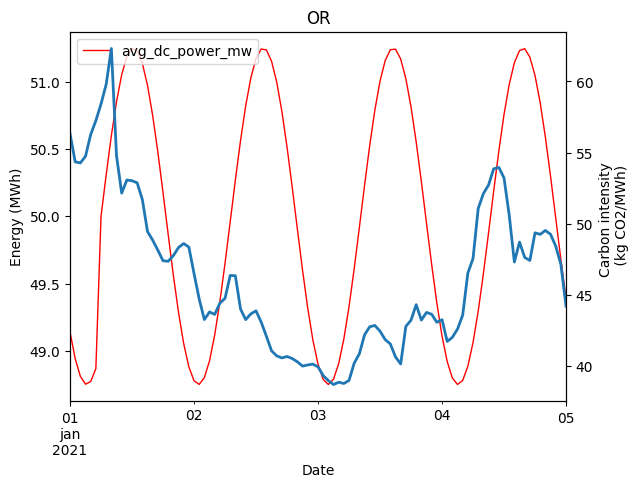

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



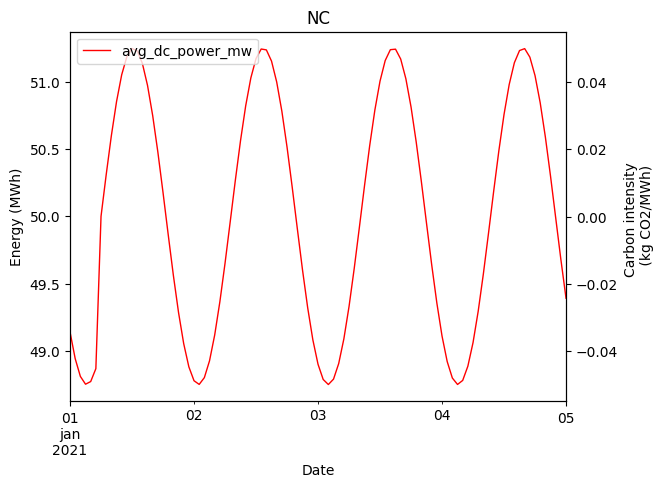

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



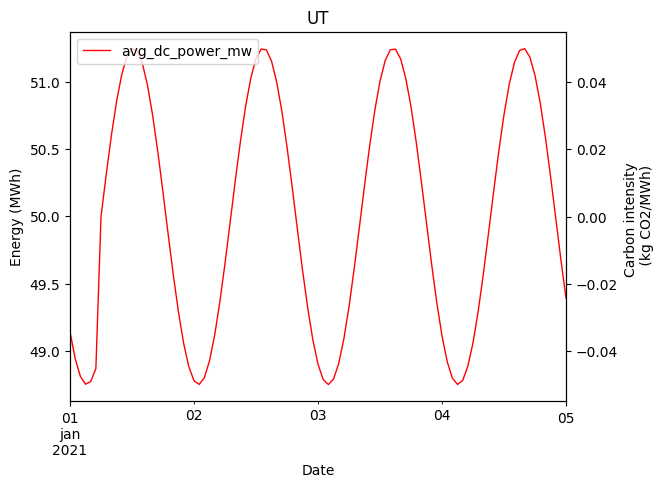

In [20]:
# Plot DC power usage and the carbon intensity of the corresponding grid

# Simulate each datacenter in our map
for dc in dc_ba_map:
    d = extractDCRange(dc, START_DATE, END_DATE)
    ax = d.plot(kind="line", color="red", lw=1)

    db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
    carbon_intensity = calculateAVGCarbonIntensity(db)
    carbon_intensity.plot(
        kind="line", stacked=False, title=dc, ax=ax, secondary_y=True, lw=2
    )

    ax.legend(loc="upper left")
    ax.set_xlabel("Date")
    ax.set_ylabel("Energy (MWh)")
    ax.right_ax.set_ylabel("Carbon intensity \n (kg CO2/MWh)")
    plt.show()

# 2. Battery Analysis

**Charging:** Whenever  there  is  excess  renewable  supply  (i.e.  when  theamount  of  energy  produced  by  the  renewable  deployment  islarger  than  datacenter’s  demand),  batteries  will  be  charged.

**Discharging:** Whenever there is lack of renewable supply (i.e.when the amount of energy produced by the renewable deployment is smaller than datacenter’s demand) batteries will be discharged to power the datacenter.

The algorithm assumes a fixed charging speed and can charge as much as there is excess supply. Charging capacity does not change depending on the load of the batteries.

The next cell calculates the minimim battery capacity that needs to be deployed in order to make datacenter operate on renewable energy 24/7 given different solar and wind investments.

## 2.1 Function for generic Battery Analysis

In [29]:
import seaborn as sns
import utils
import batteries.battery_utils as bat
import importlib

importlib.reload(bat)

<module 'batteries.battery_utils' from '/home/bendm/CarbonExplorer/src/batteries/battery_utils.py'>

In [36]:
print("Battery module path:", os.path.abspath(bat.__file__))

Battery module path: /home/bendm/CarbonExplorer/src/batteries/battery_utils.py


In [ ]:
def battery_analysis(search_fun,battery_type="b2"):
    battery_results_map = []
    # maximum renewable capacity to be evaluated
    max_wind_range = 1000
    max_sol_range = 1000

    for dc in dc_ba_map:
        ba = dc_ba_map[dc]
        d = extractDCRange(dc, START_DATE, END_DATE)
        db = extractBARange(dc_ba_map[dc], START_DATE, END_DATE)
        db[db < 0] = 0
        max_dc_pow = d.max().item()
        wnd_db = db["WND"].fillna(0)
        sun_db = db["SUN"].fillna(0)
        max_wnd_cap = wnd_db.max()
        max_sun_cap = sun_db.max()

        results_bat = pd.DataFrame(
            columns=["sun_capacity", "wnd_capacity", "coverage", "battery_cap"]
        )

        max_wind_range += ba_ppa_map[ba][0]
        max_sol_range += ba_ppa_map[ba][1]
        for wnd_capacity in range(
            0, max_wind_range + 1, int(int(max_wind_range / 8) / 10) * 10
        ):
            for sun_capacity in range(
                0, max_sol_range + 1, int(int(max_sol_range / 8) / 10) * 10
            ):
                wnd_db_scaled = wnd_db
                sun_db_scaled = sun_db
                if max_wnd_cap != 0:
                    wnd_db_scaled = wnd_db / max_wnd_cap * wnd_capacity
                if max_sun_cap != 0:
                    sun_db_scaled = sun_db / max_sun_cap * sun_capacity
                projected_db = pd.concat([wnd_db_scaled, sun_db_scaled], axis=1)

                ren_mw = wnd_db_scaled + sun_db_scaled
                battery_cap_needed = bat.calculate_247_battery_capacity(
                    ren_mw, d, search=search_fun, battery_type=battery_type
                )
                print("Battery capacity needed: ", battery_cap_needed)

                # Calculate renewable coverage
                renewable_coverage_ratio = utils.calculate_coverage(
                    ren_mw, d["avg_dc_power_mw"]
                )

                results_bat.loc[results_bat.shape[0]] = [
                    sun_capacity,
                    wnd_capacity,
                    renewable_coverage_ratio,
                    battery_cap_needed,
                ]

        # Plot the results
        fig = plt.figure(figsize=(30, 8))
        # FIRST PLOT
        plt.rcParams.update({"font.size": 18})
        ax = fig.add_subplot(1, 3, 1, projection="3d")
        ax.plot_trisurf(
            results_bat["sun_capacity"],
            results_bat["wnd_capacity"],
            results_bat["coverage"],
            cmap=plt.cm.Greens,
            linewidth=0.2,
        )
        ax.set_xlabel("Solar Capacity [MW]", labelpad=15)
        ax.set_ylabel("Wind Capacity [MW]", labelpad=15)
        ax.set_zlabel("24/7 Coverage [%]", labelpad=15)
        ax.set_title(dc)
        ax.set_zlim(0, 100)
        ax.dist = 13
        # SECOND PLOT
        ax = fig.add_subplot(1, 3, 2)
        results_bat.drop(["coverage"], axis=1, inplace=True)
        results_bat = results_bat.fillna(-1).astype("int")
        results_bat["battery_cap"] = results_bat["battery_cap"] / max_dc_pow
        results_bat["battery_cap"] = results_bat["battery_cap"][
            results_bat["battery_cap"] >= 0.0
        ]
        rp = results_bat.pivot(
            index="sun_capacity", columns="wnd_capacity", values="battery_cap"
        )
        # pd.options.display.float_format = '{:,}'.format
        s = sns.heatmap(
            rp,
            cmap=plt.cm.Blues,
            ax=ax,
            cbar_kws={"label": "Battery Required for 24/7 [Hours of Capacity]"},
            annot=True,
            fmt=".1f",
            vmin=0,
            vmax=24,
        )
        ax.invert_yaxis()
        ax.set_ylabel("Solar Capacity [MW]", labelpad=15)
        ax.set_xlabel("Wind Capacity [MW]", labelpad=15)
        s.set_facecolor("whitesmoke")

        # THIRD PLOT
        ax = fig.add_subplot(
            133,
            xlabel="Total Renewable Capacity [MW]",
            ylabel="Battery Footprint for 24/7 [kilotons of CO2]",
        )
        results_bat["battery_cap"] = results_bat["battery_cap"][
            results_bat["battery_cap"] >= 0.0
        ]  # do not plot -1s, infeasible battery cases
        # embodied carbon footprint of batteries for 10 years, in terms of kilotons of CO2 (divide by 1000)
        results_bat["battery_cap"] = (
            results_bat["battery_cap"]
            * (embodied_battery_footprint / 1000)
            * (10 / battery_lifetime)
        )
        ax.scatter(
            results_bat["sun_capacity"] + results_bat["wnd_capacity"],
            results_bat["battery_cap"],
        )
        ax.set_ylim(bottom=0)
        plt.show()
        battery_results_map.append(pickle.loads(pickle.dumps(results_bat)))
    return battery_results_map

## 2.2 Testing different battery analysis methods

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  4852.298107505284
Battery capacity needed:  3108.9647741719523
Battery capacity needed:  1758.2545039587758
Battery capacity needed:  1211.9121508089672
Battery capacity needed:  948.5788174756339
Battery capacity needed:  803.8367976798047
Battery capacity needed:  800.5342001850721
Battery capacity needed:  800.5342001850721
Battery capacity needed:  800.5342001850721
Battery capacity needed:  566.6084393071679
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  345.889394091941
Battery capacity needed:  242.08914668152795
Battery capacity needed:  153.61386365991984
Battery capacity needed:  153.61386365991984
Battery capacity needed:  153.61386365991984
Battery capacity needed:  153.613

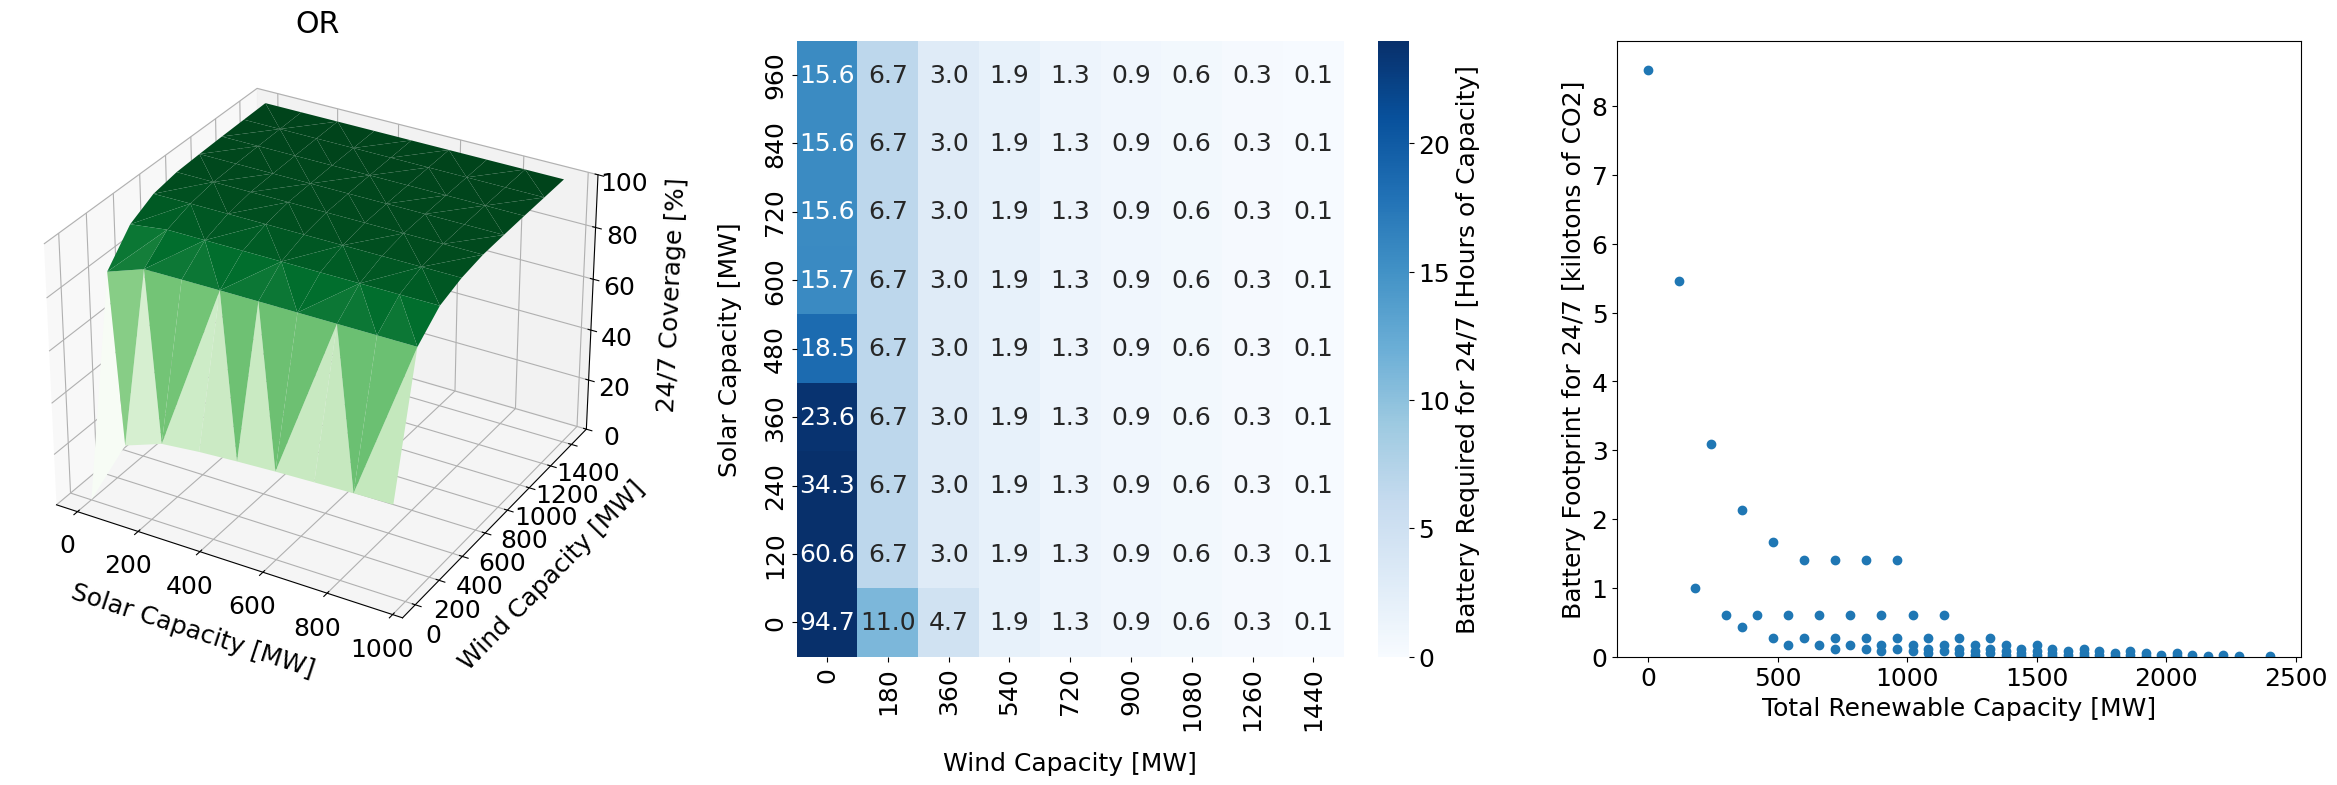

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.2

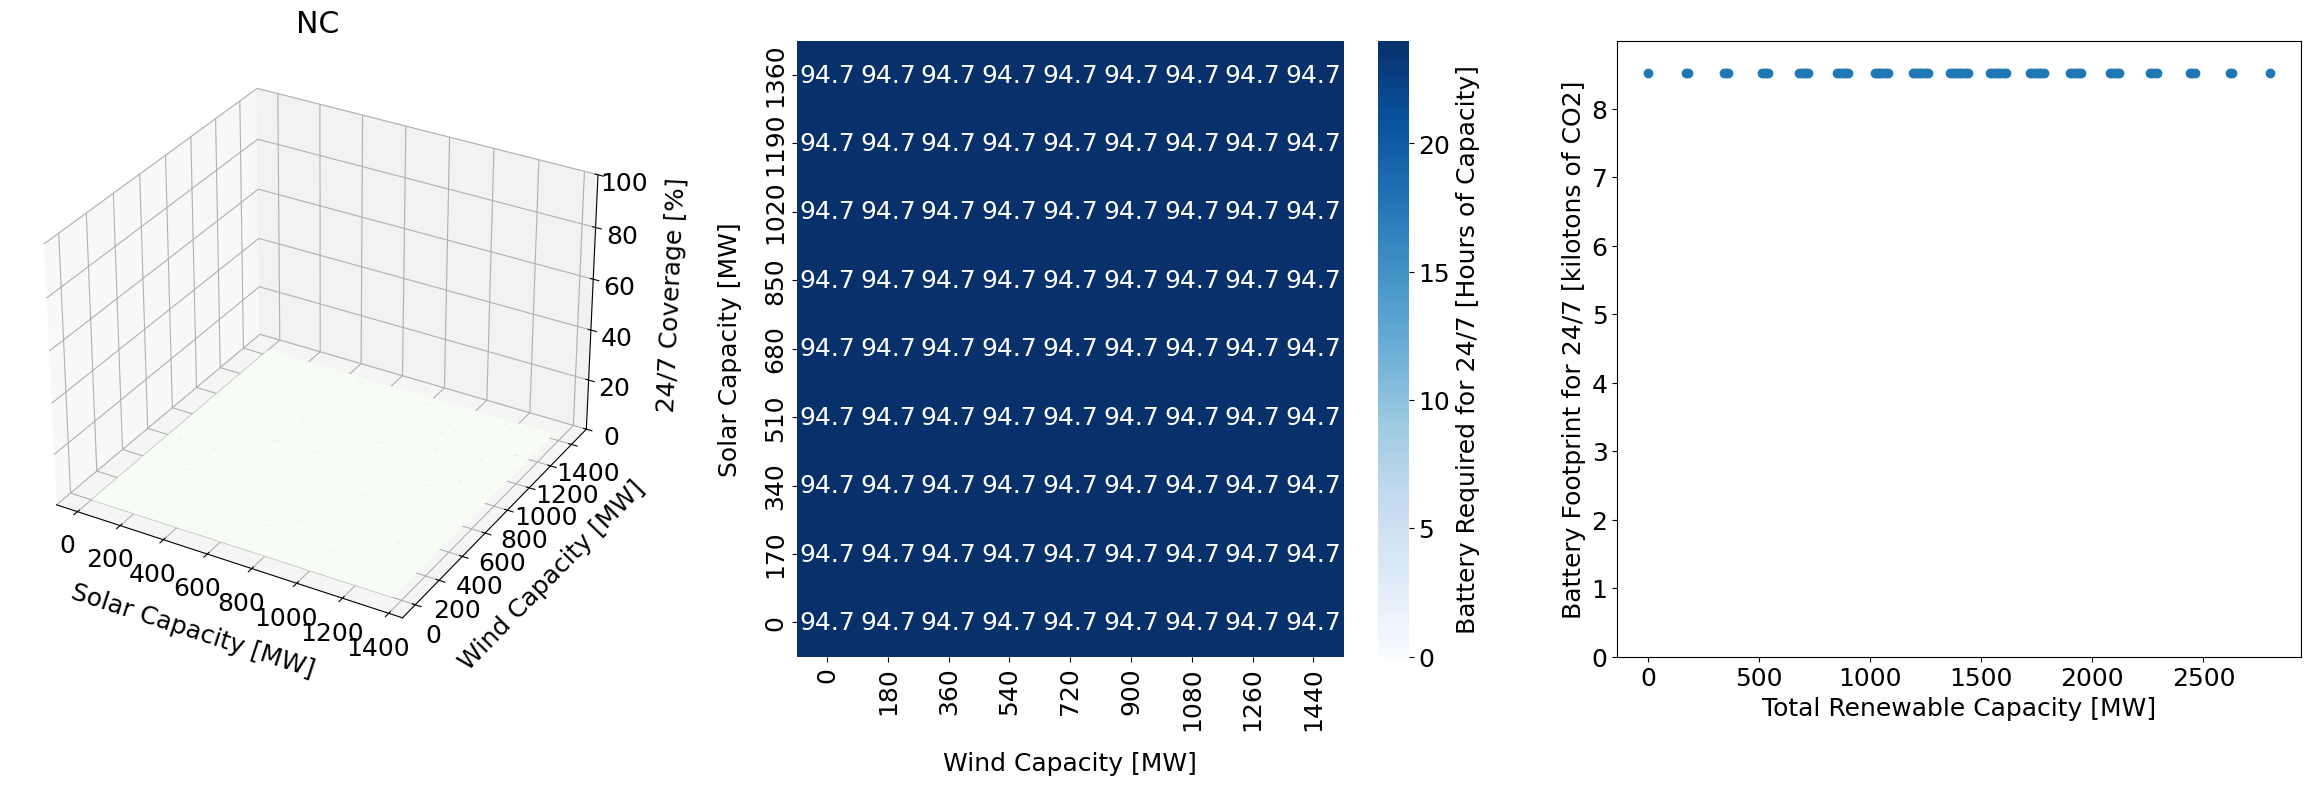

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.298107505284
Battery capacity needed:  4852.2

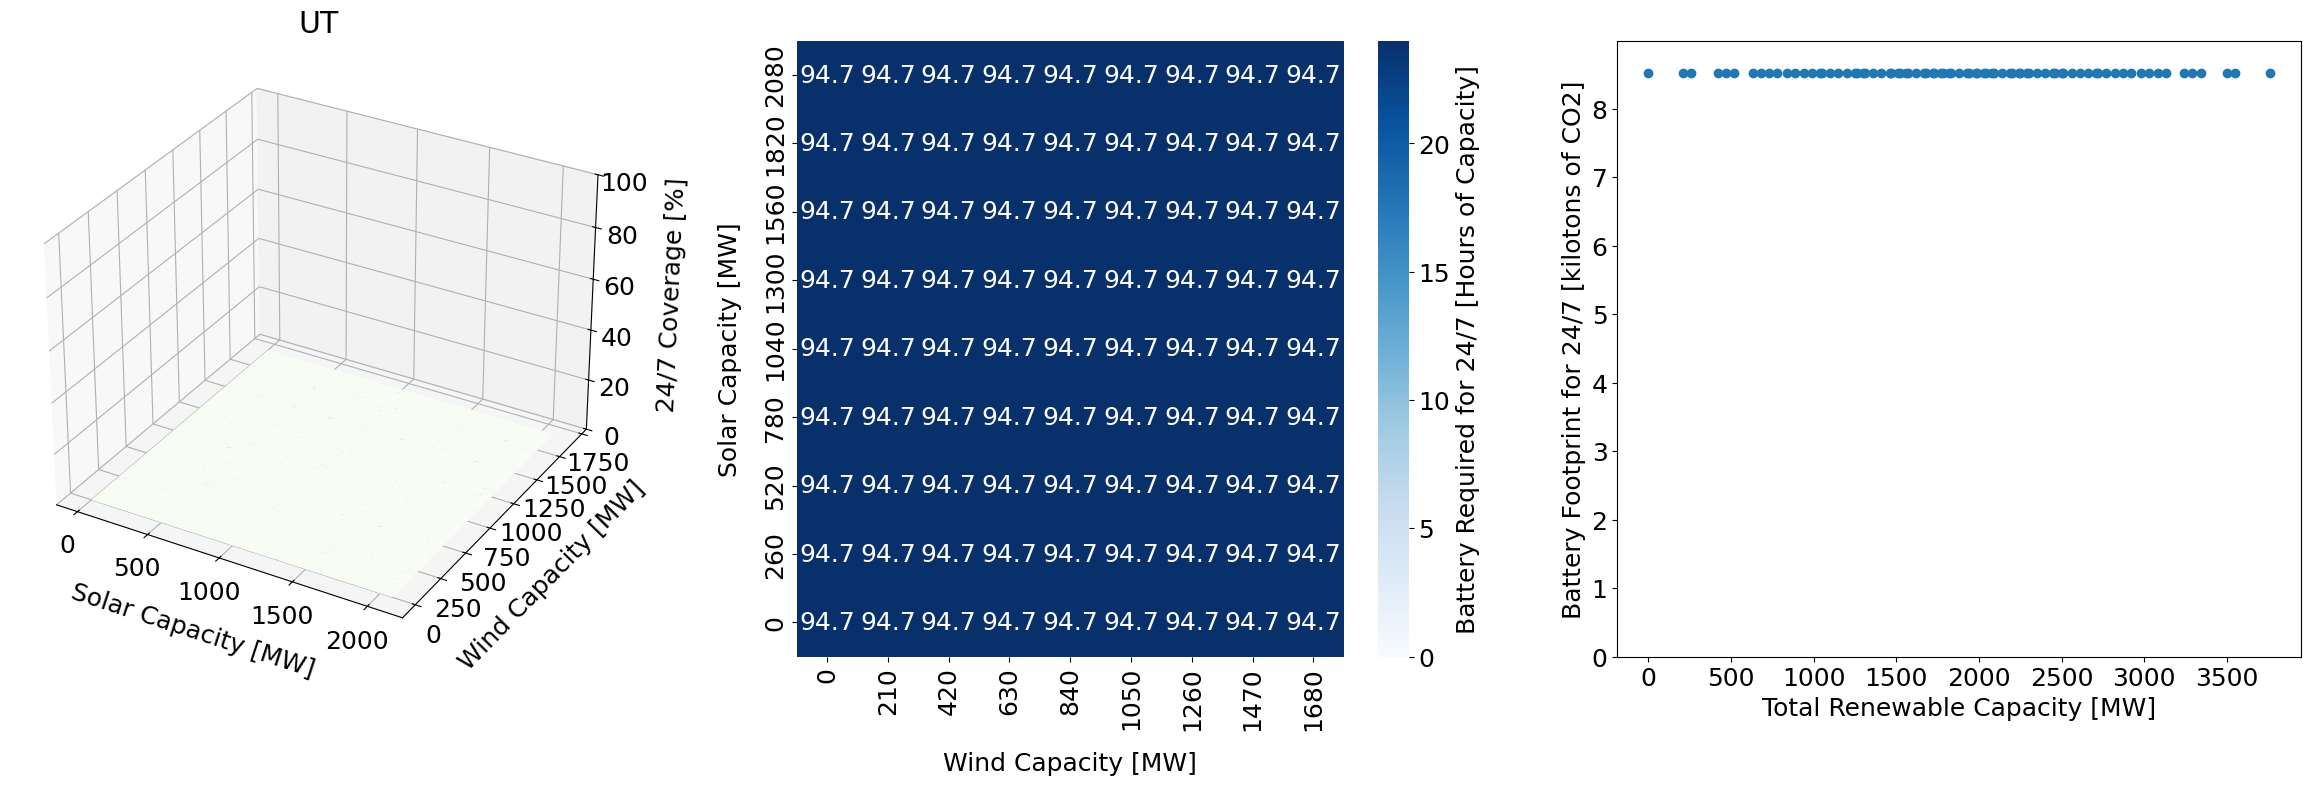

In [41]:
battery_analysis("sequential", battery_type="b1")

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5099.690031805508
Battery capacity needed:  3761.1530017857735
Battery capacity needed:  3478.087821387847
Battery capacity needed:  3390.152099533618
Battery capacity needed:  3346.5033106134497
Battery capacity needed:  3312.0566439467834
Battery capacity needed:  3286.6671191555215
Battery capacity needed:  3262.547119155522
Battery capacity needed:  3243.236788178048
Battery capacity needed:  957.0512240998723
Battery capacity needed:  704.0391325037896
Battery capacity needed:  698.7195861839687
Battery capacity needed:  695.3106972950798
Battery capacity needed:  695.1347089809519
Battery capacity needed:  695.1347089809519
Battery capacity needed:  695.1347089809519
Battery capacity needed:  695.1347089809519
Battery capacity needed:  695.1347089809519
Battery capacity needed:  398.68540266320616
Battery capacity needed:  305.47110832073355
Battery capacity needed:  305.47110832073355
Battery capacity needed:  305.47110832073355
Battery capacity needed:

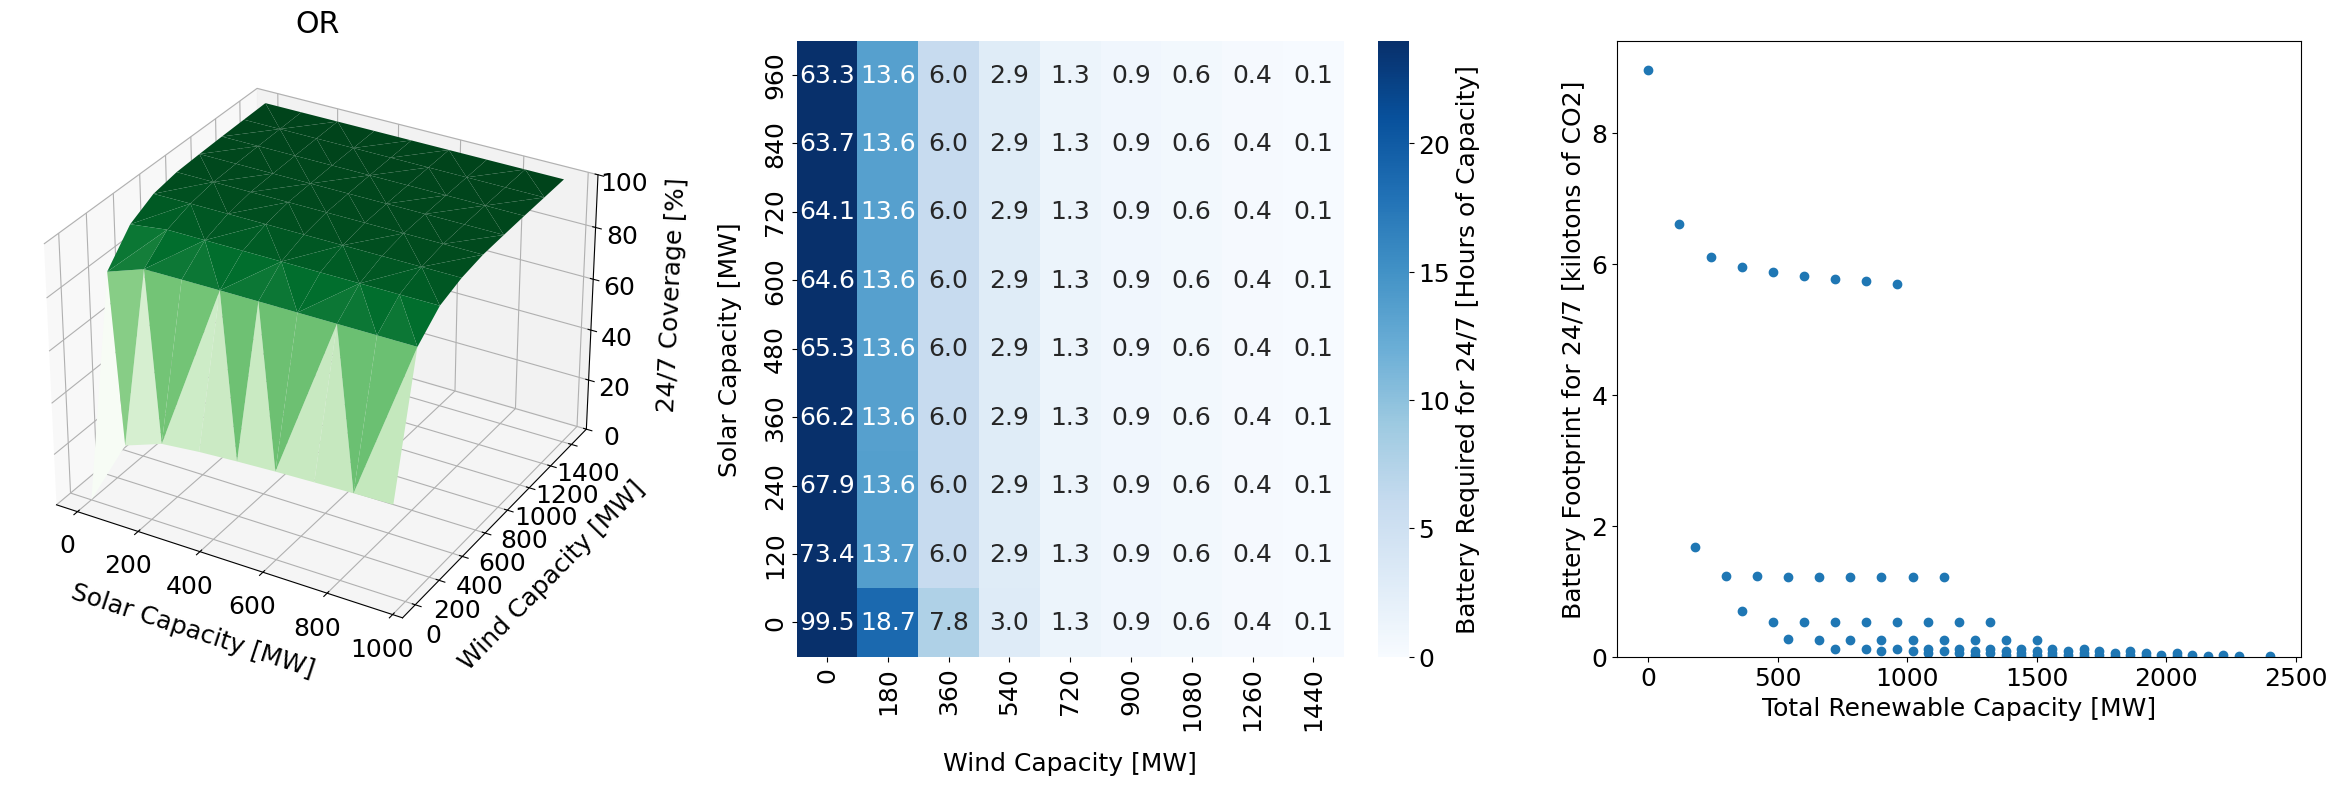

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.6

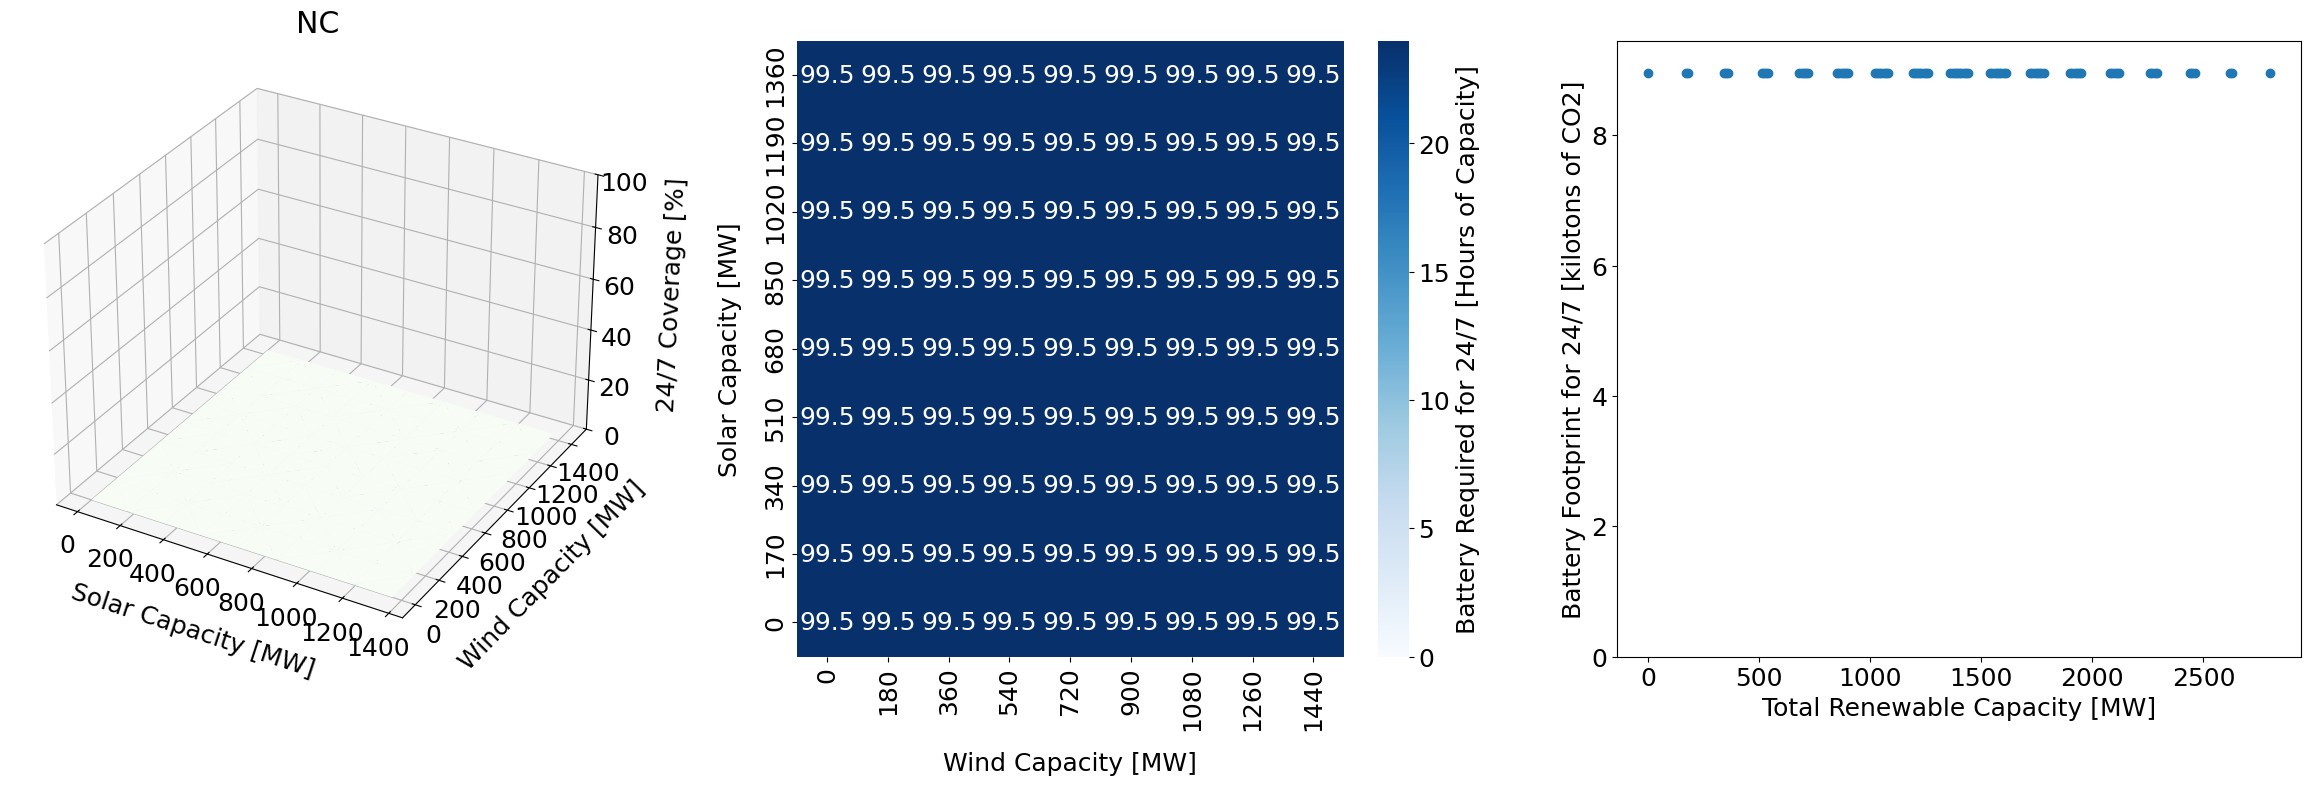

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.690031805508
Battery capacity needed:  5099.6

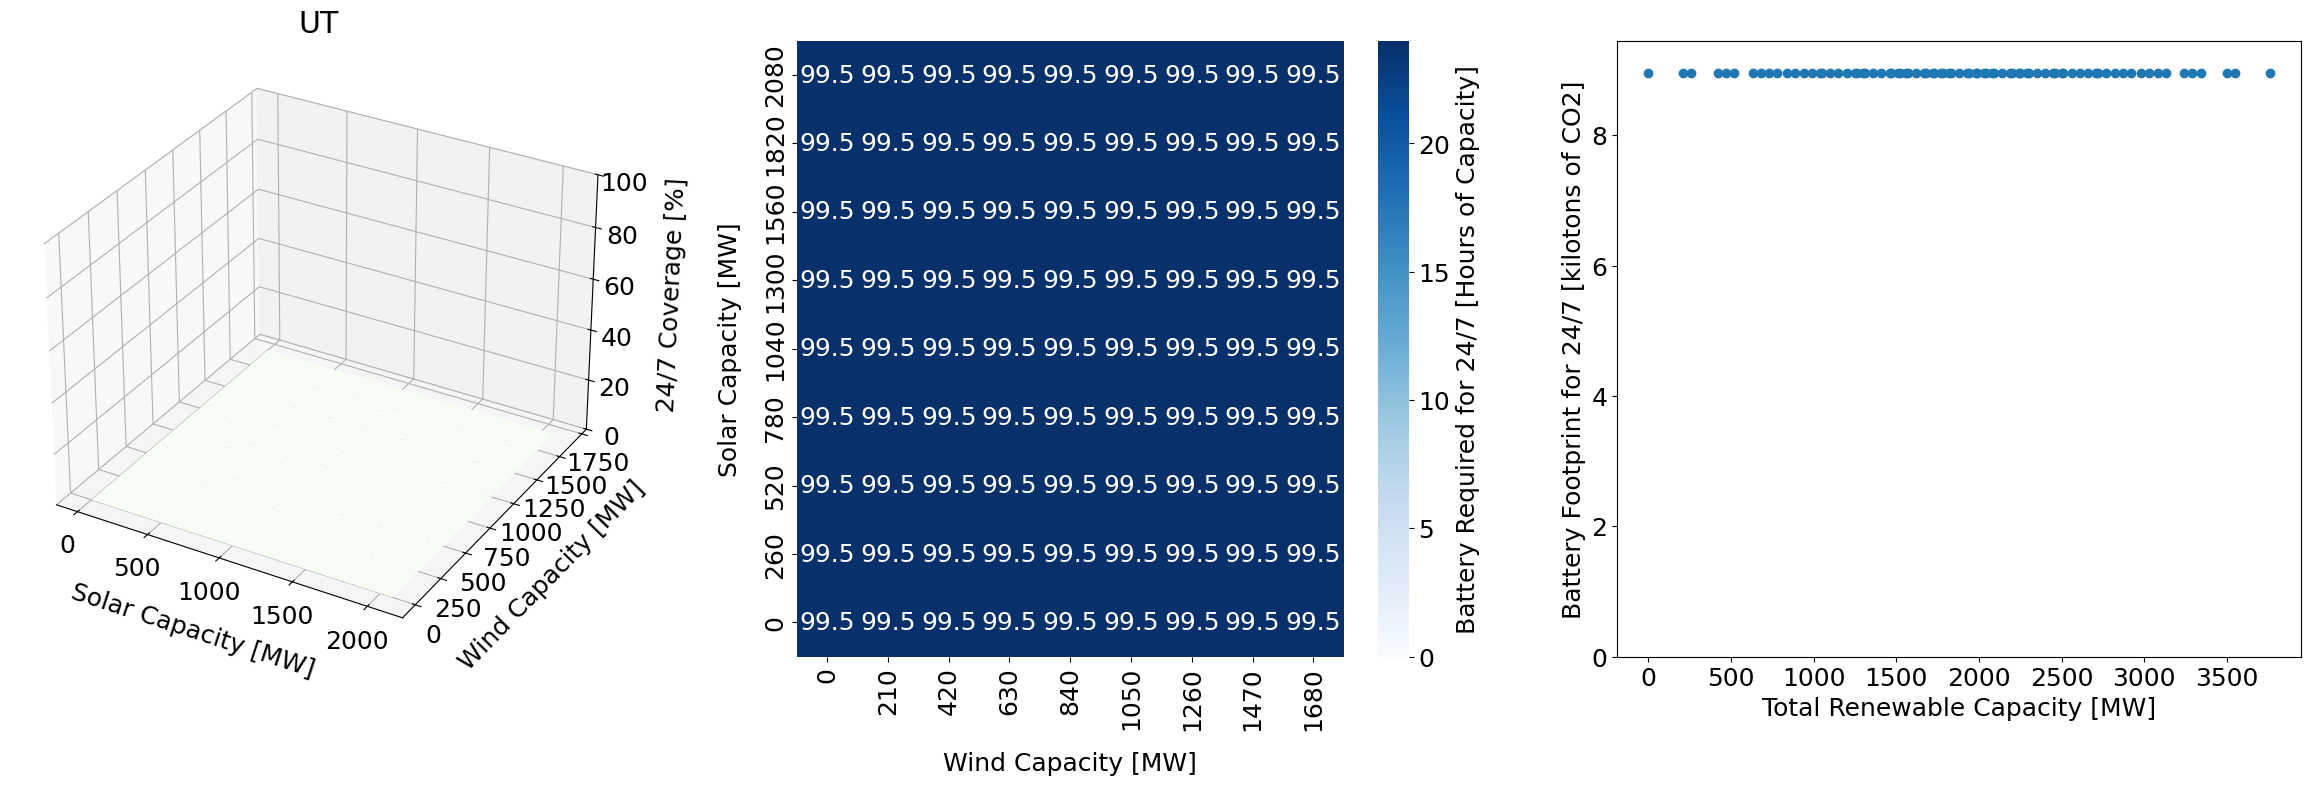

In [42]:
battery_analysis("sequential",battery_type="b2")

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  288223.86264801025
Battery capacity needed:  184507.90643692017
Battery capacity needed:  103663.6233329773
Battery capacity needed:  69695.83034515381
Battery capacity needed:  53895.83110809326
Battery capacity needed:  47950.20818710327
Battery capacity needed:  46994.149684906006
Battery capacity needed:  46787.50038146973
Battery capacity needed:  45013.12971115112
Battery capacity needed:  33402.14490890503
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  20442.12818145752
Battery capacity needed:  14089.107513427734
Battery capacity needed:  8552.014827728271
Battery capacity needed:  8552.014827728271
Battery capacity needed:  8552.014827728271
Battery capacity needed:  85

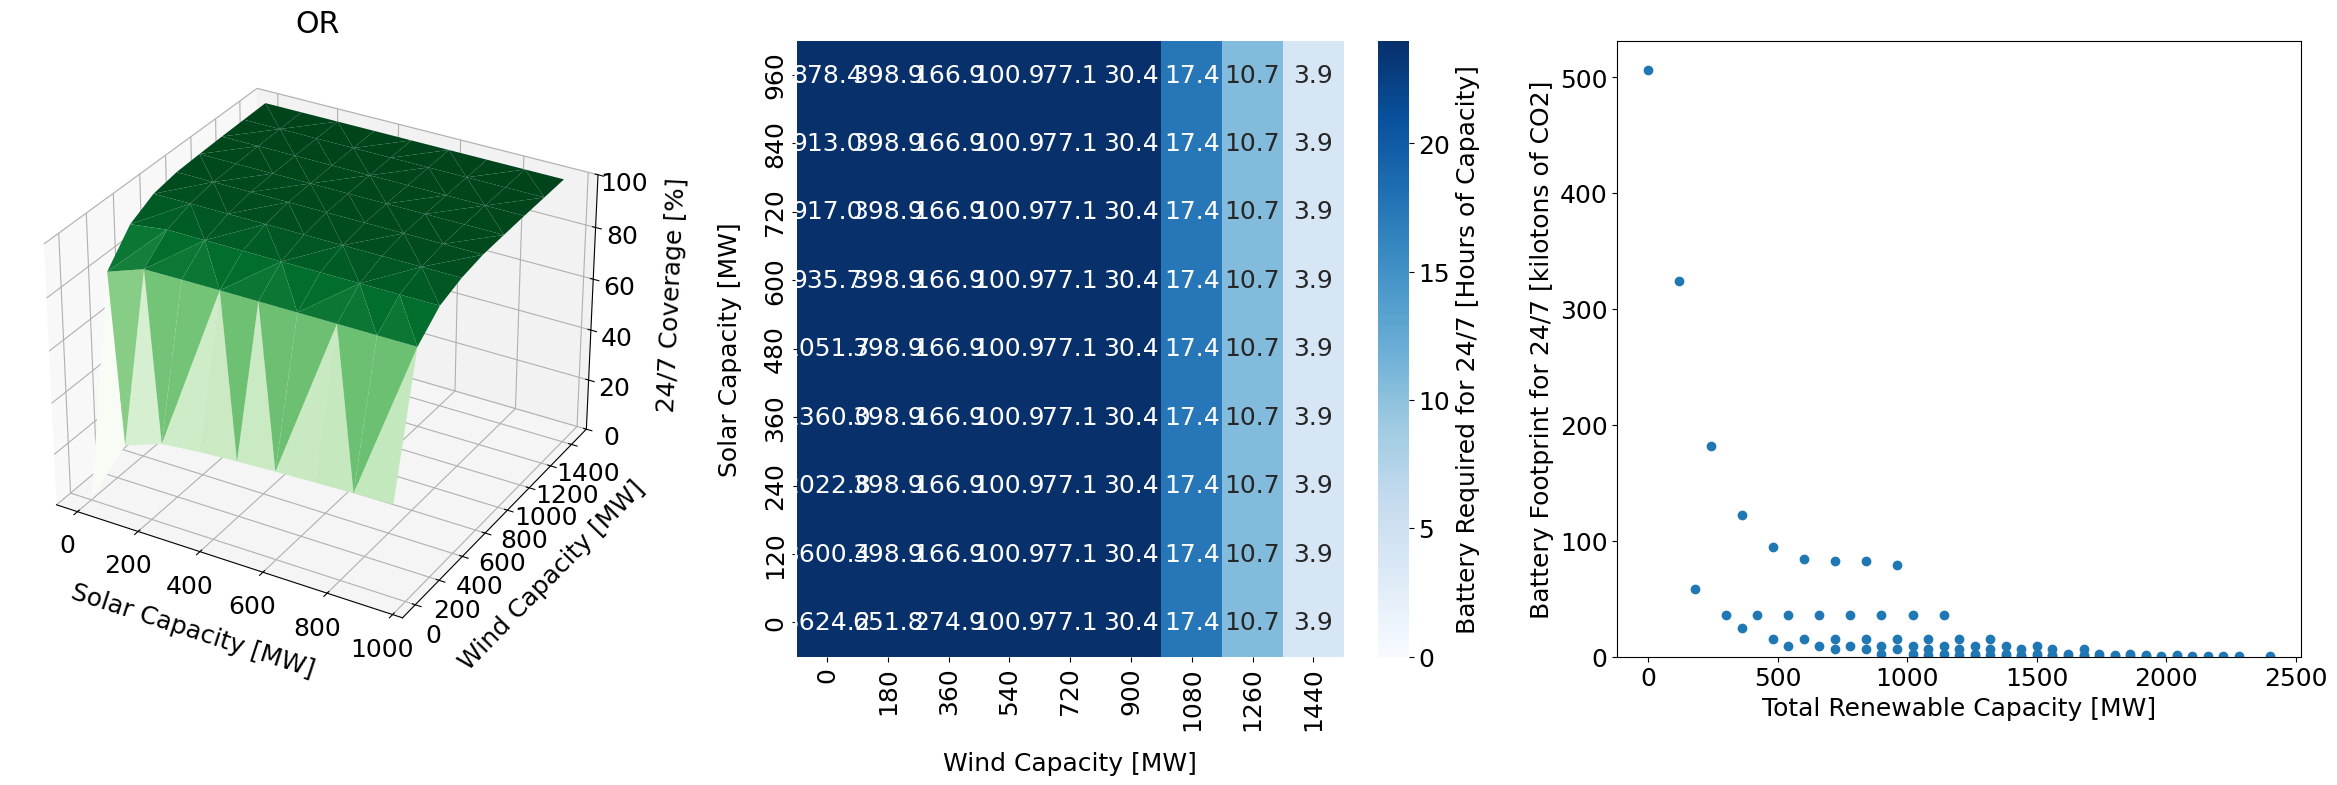

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery ca

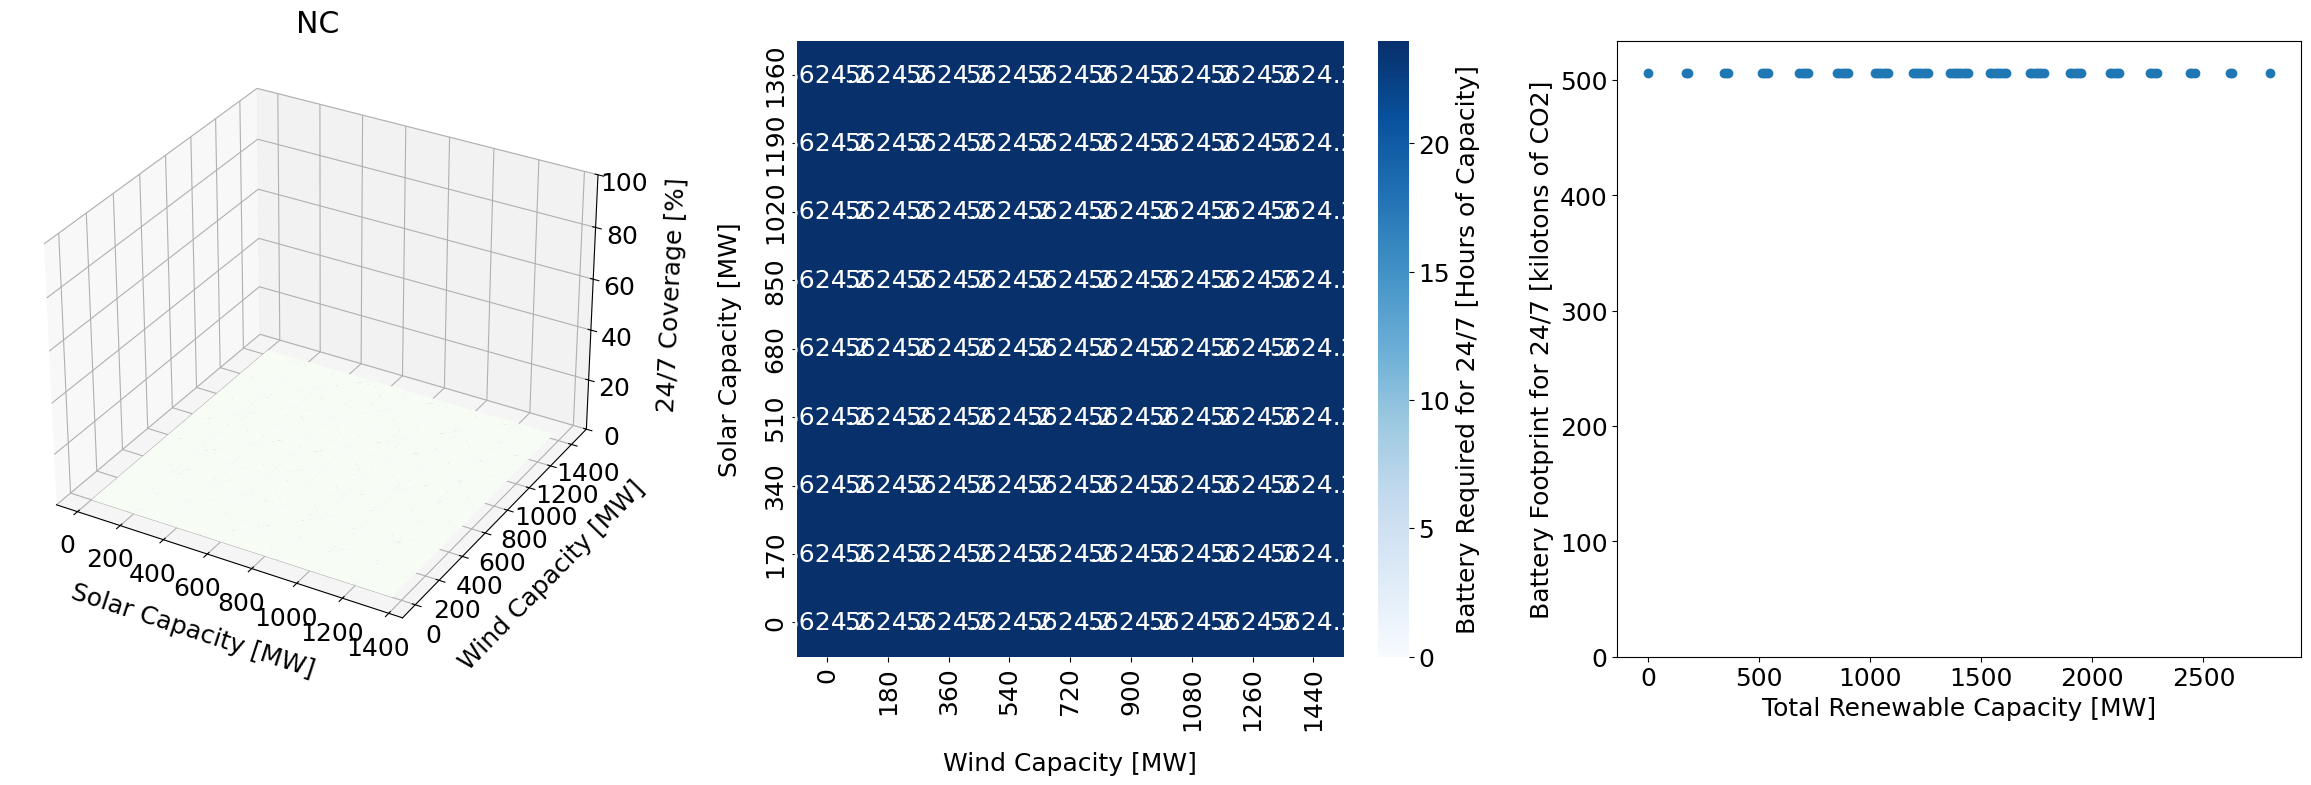

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery capacity needed:  288223.86264801025
Battery ca

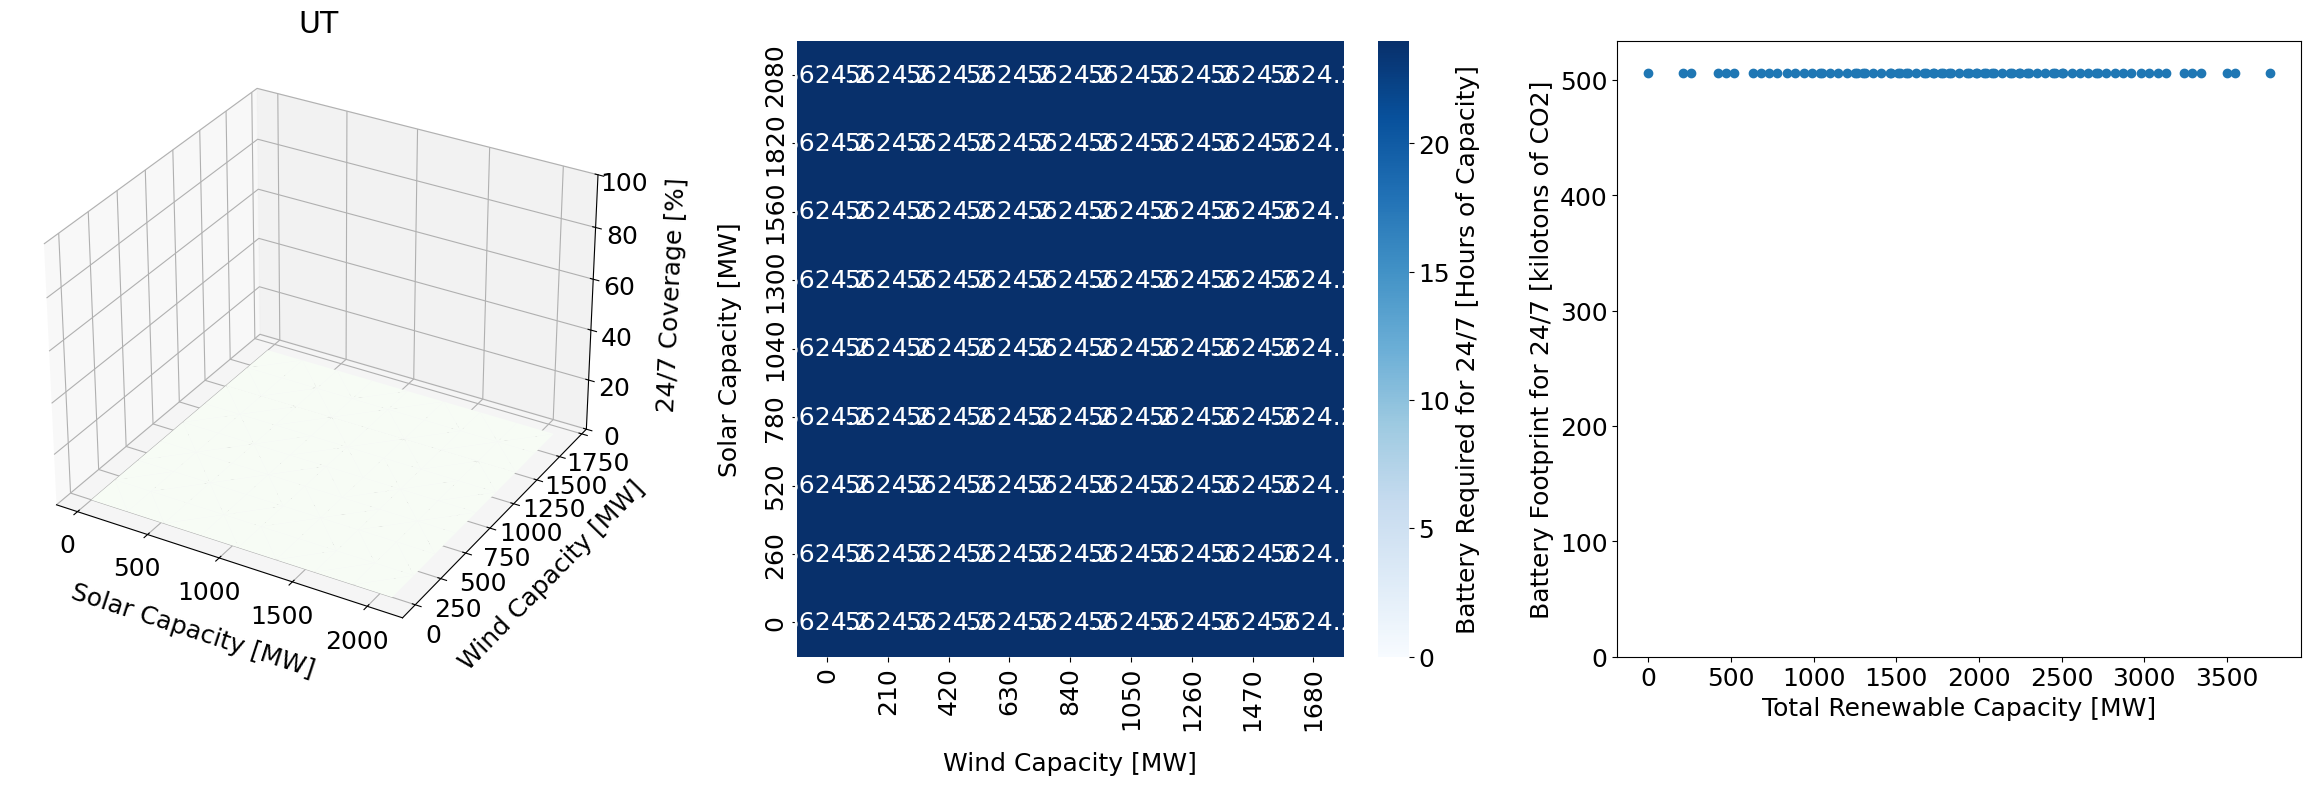

In [43]:
battery_analysis("binary",battery_type="b1")

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5046.90408706665
Battery capacity needed:  3266.93058013916
Battery capacity needed:  1883.5663795471191
Battery capacity needed:  1290.440559387207
Battery capacity needed:  1033.6637496948242
Battery capacity needed:  836.1935615539551
Battery capacity needed:  833.0941200256348
Battery capacity needed:  833.0941200256348
Battery capacity needed:  833.0941200256348
Battery capacity needed:  589.4303321838379
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  359.8332405090332
Battery capacity needed:  251.88922882080078
Battery capacity needed:  159.91926193237305
Battery capacity needed:  159.91926193237305
Battery capacity needed:  159.91926193237305
Battery capacity needed:  15

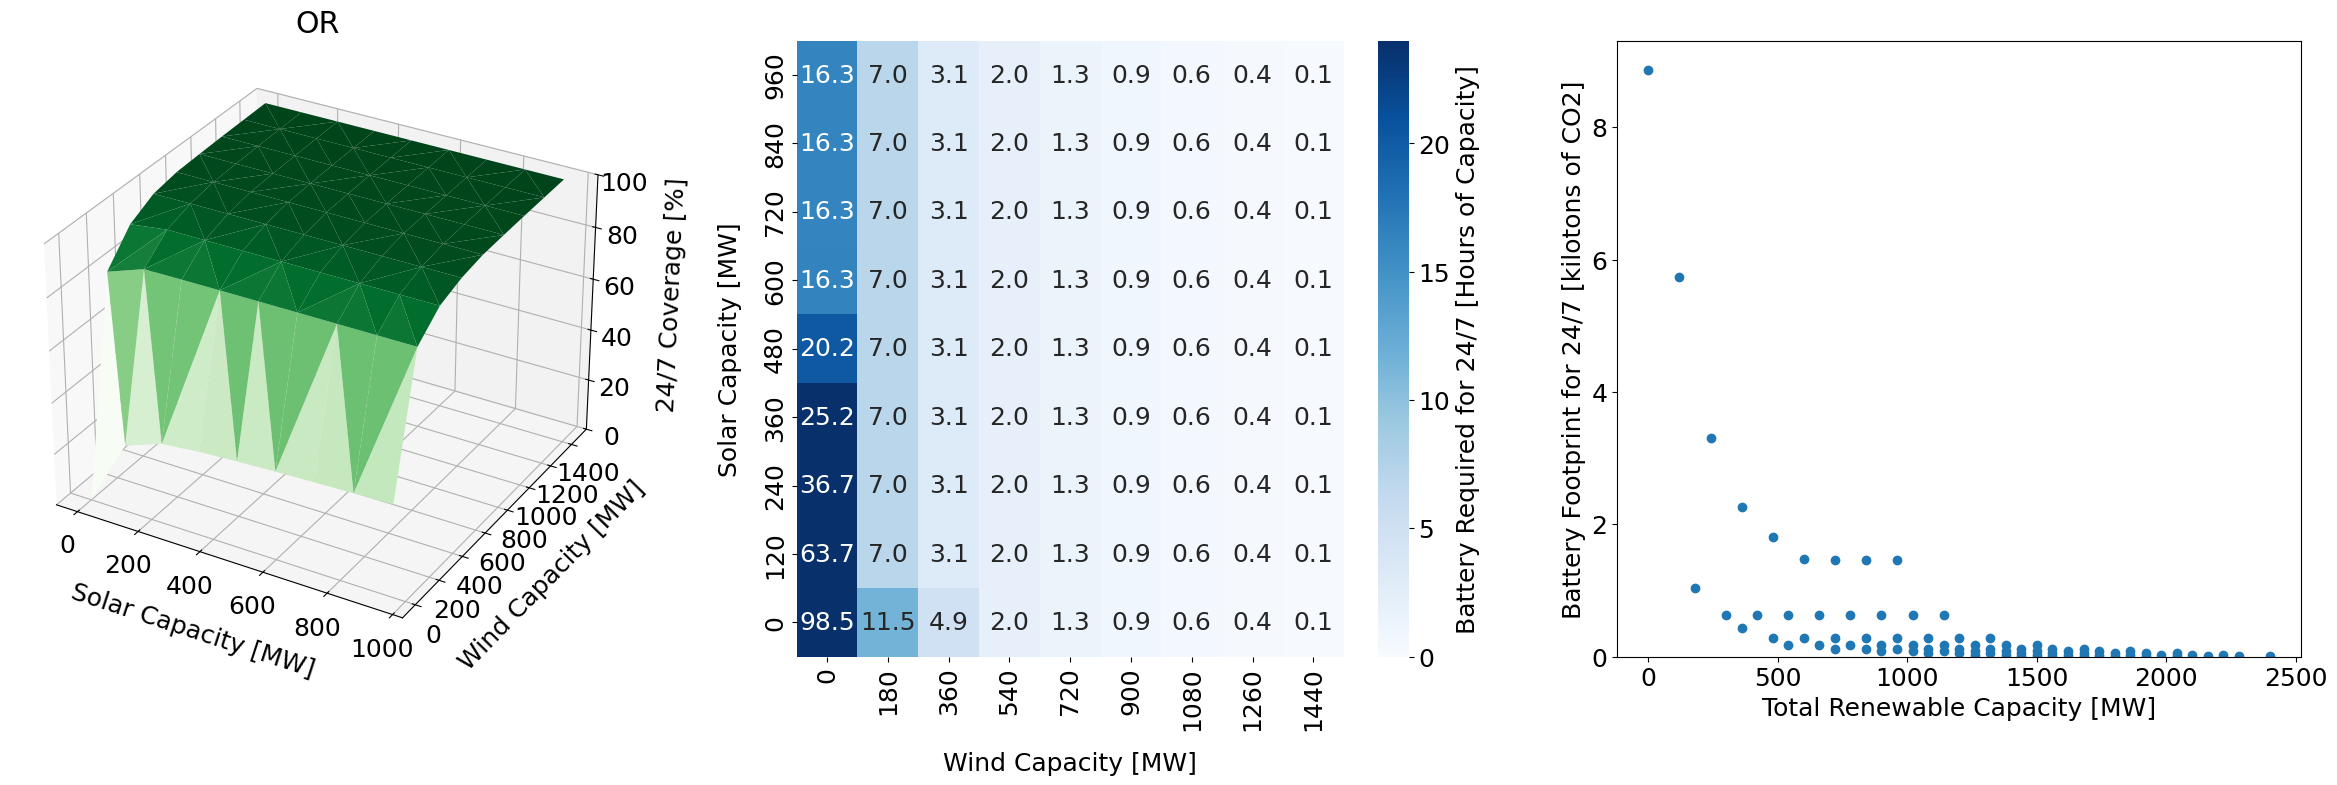

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery cap

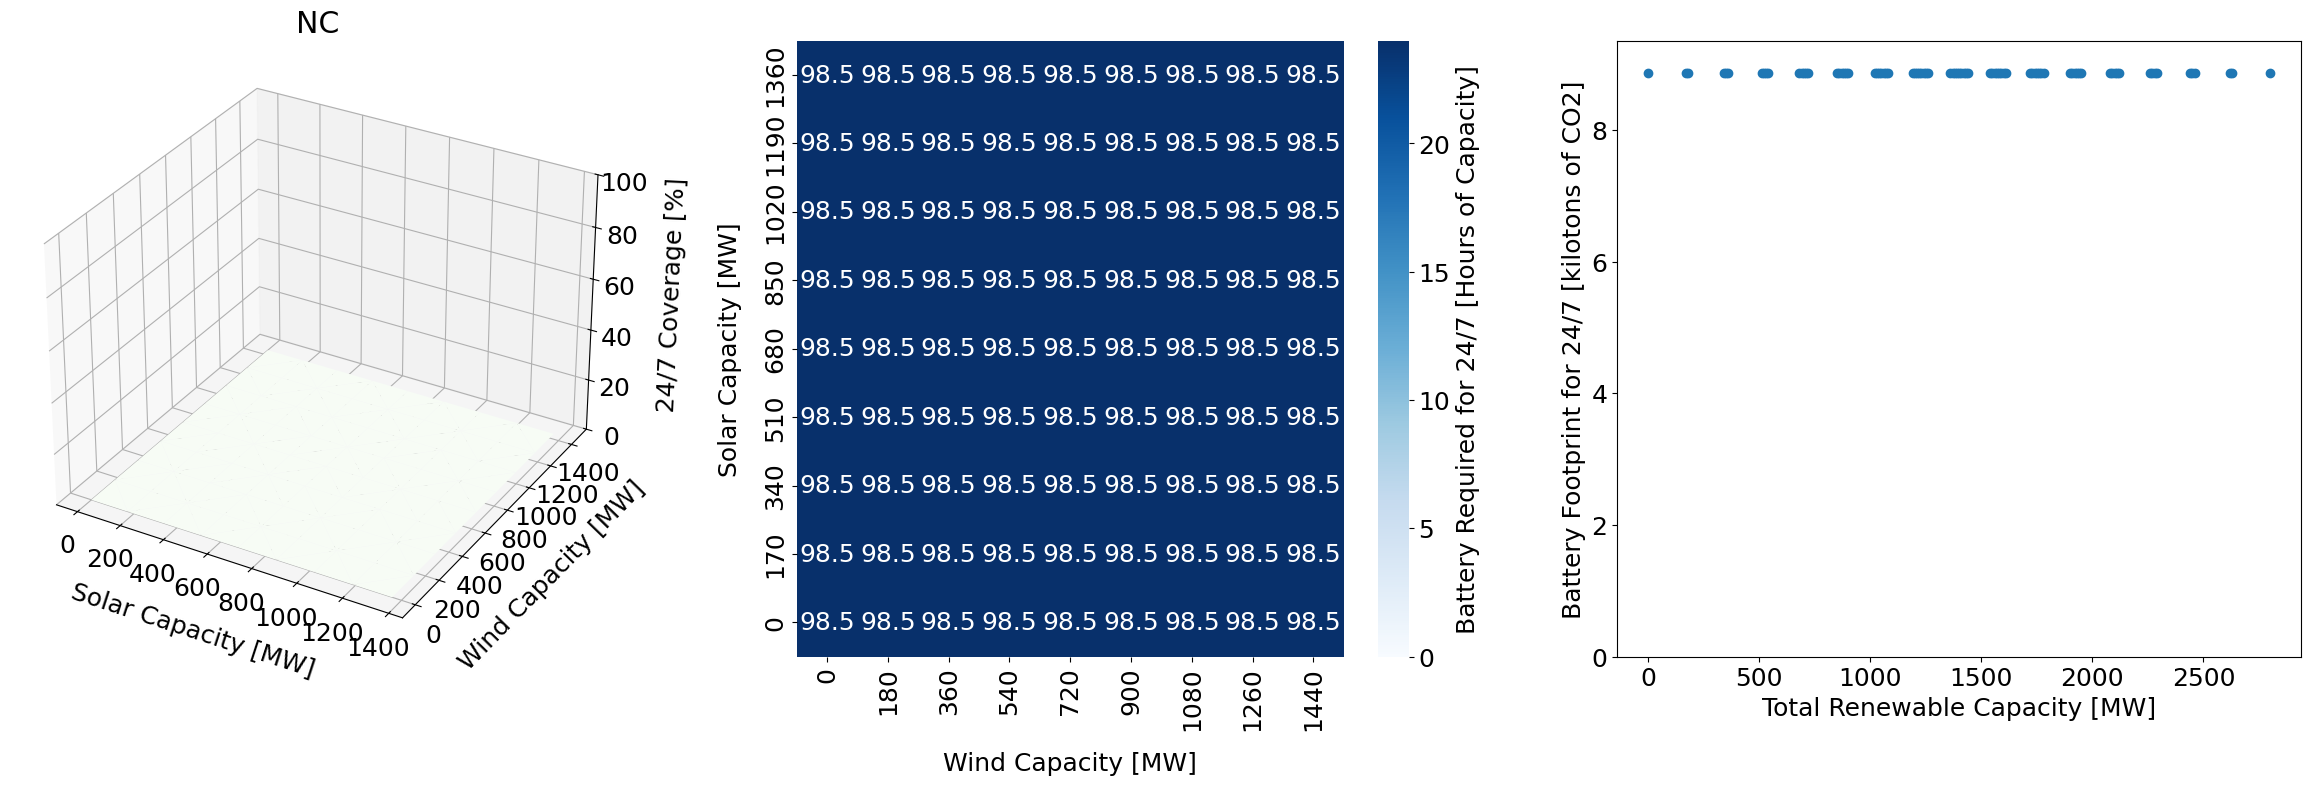

/tmp/ipykernel_105399/3728073631.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:112: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/home/bendm/CarbonExplorer/src/download_and_process.py:158: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery capacity needed:  5046.90408706665
Battery cap

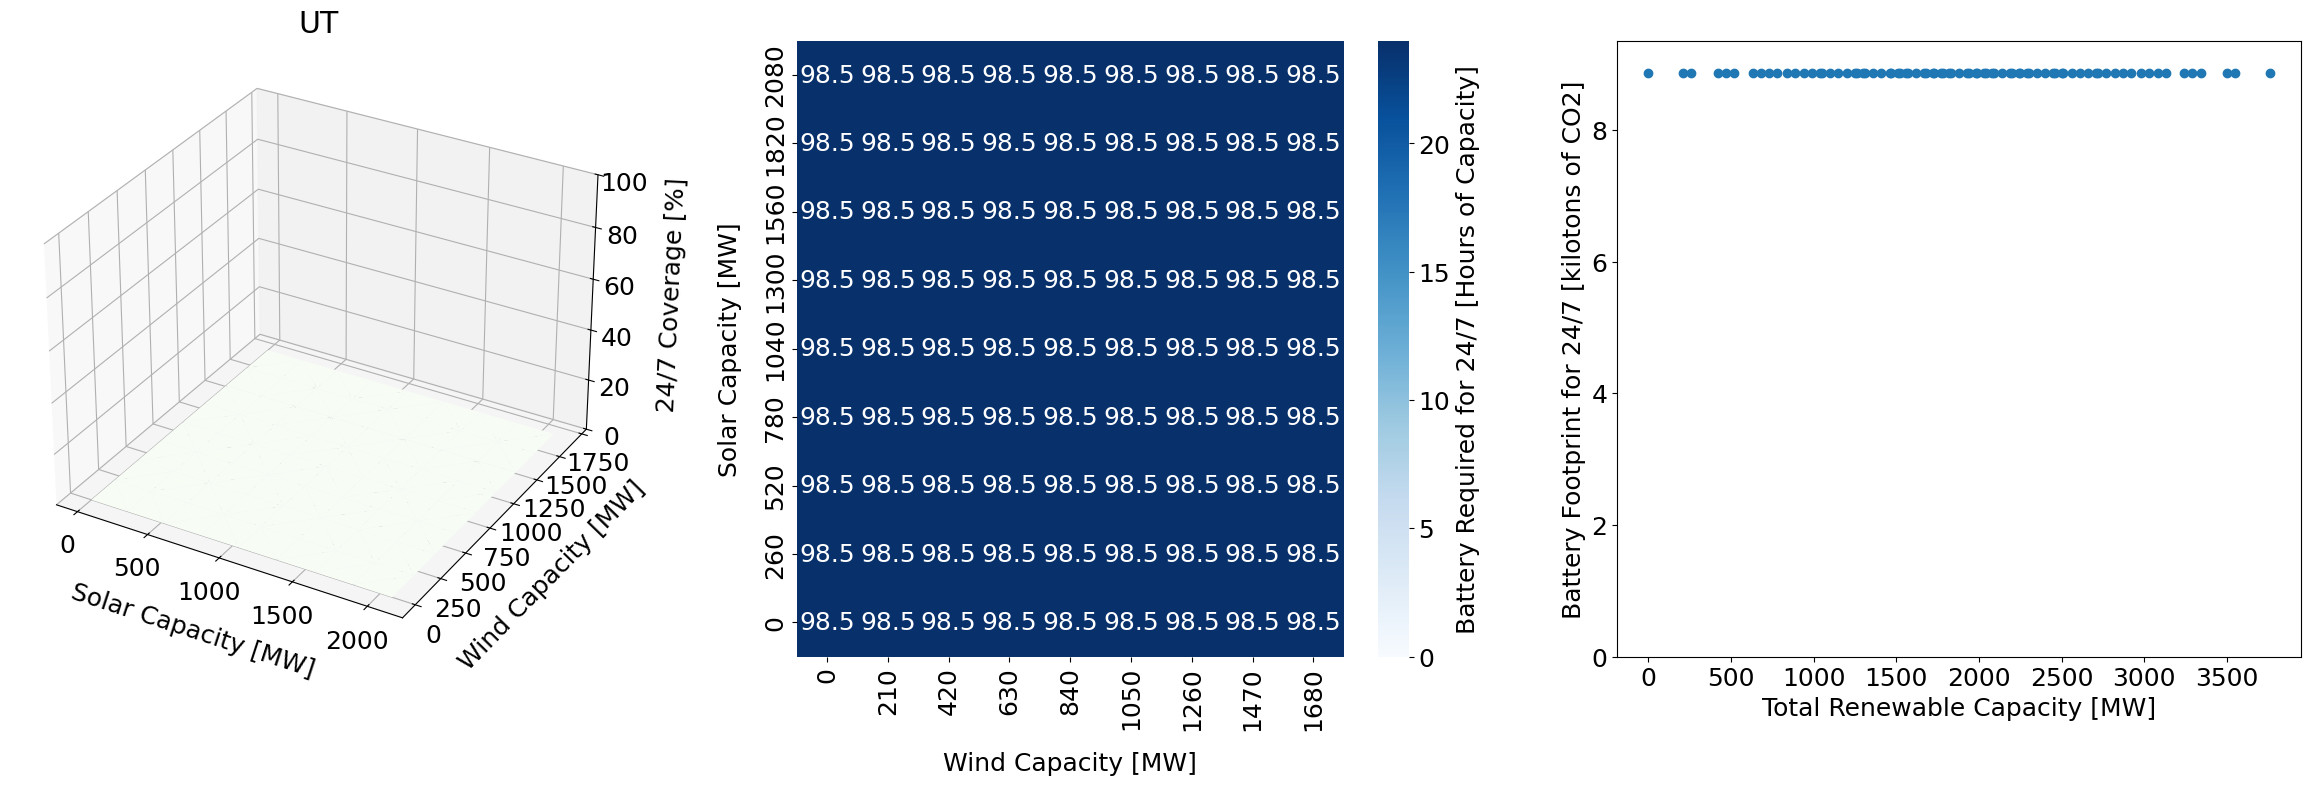

In [44]:
battery_analysis("binary",battery_type="b2")